In [35]:
from influxdb_client import InfluxDBClient
import os 
import matplotlib.pyplot as plt
from datetime import datetime 
from datetime import timedelta
import pandas as pd
import os
import math
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg


In [36]:
# Read data from database
standort_liste = ['Fontanestraße_2309','Georg-Eckert-Straße_0491','Georg-Westermann-Allee_2311',
                  'Georg-Westermann-Park_2297', 'Langer-Kamp_1983', 'Lünischkamp_2548',
                  'Max-Osterloh-Platz_3299', 'Museumspark_0520', 'Schillstraße_0601']
standort = standort_liste[3]
start_date = '2023-10-10T12:00:00Z'
start_date_datetime = datetime.strptime(start_date, '%Y-%m-%dT%H:%M:%SZ')
end_date = '2024-02-01T12:00:00Z'
end_date_datetime = datetime.strptime(end_date, '%Y-%m-%dT%H:%M:%SZ')
list_of_depth = ['15', '30', '50', '100','200']
gesamtframe = []

for i, depth in enumerate(list_of_depth):
    with InfluxDBClient(
        url="https://database.isodrones.de",
        token="AWAE4XarwTdDkgePJp-hvLDqV-lKBuUYecVc4RFqYpddJxD_-ICSK8E_AUksqSJ6i5_qp8e_QHk9D5B4kxvs9Q==",
        org="isodrones",
        debug=False,
    ) as client:
        query_api = client.query_api()
        data_frame = (query_api.query_data_frame('''
        from(bucket:"climax2") 
            |> range(start: %s, stop: %s) 
            |> filter(fn: (r) => r["location"] == "depth_cm_%s")
            |> filter(fn: (r) => r["site"] == "%s")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value") 
        ''' % (start_date, end_date,str(depth), standort))) 
    data_frame_sortiert = data_frame.sort_values(by='_time')

    if depth == '15':
        frame_15 = data_frame_sortiert
    if depth == '30':
        frame_30 = data_frame_sortiert
    if depth == '50':
        frame_50 = data_frame_sortiert
    if depth == '100':
        frame_100 = data_frame_sortiert
    if depth == '200':
        frame_200 = data_frame_sortiert


In [37]:
# Choose only timesteps when all Sensors were active
times_vektor = []
d_15cm = []
d_30cm = []
d_50cm = []
d_100cm = []
d_200cm = []
for i, i2 in zip(frame_15['_time'], frame_15['Temperature_°C']):
    for j, j2 in zip(frame_30['_time'], frame_30['Temperature_°C']):
        if i == j:
            for k, k2 in zip(frame_50['_time'], frame_50['Temperature_°C']):
                if i == j == k:
                    for l, l2 in zip(frame_100['_time'], frame_100['Temperature_°C']):
                        if i == j == k == l:
                            for m, m2 in zip(frame_200['_time'], frame_200['Temperature_°C']):
                                if i == j == k == l == m: 
                                    times_vektor.append(i)
                                    d_15cm.append(i2)
                                    d_30cm.append(j2)
                                    d_50cm.append(k2)
                                    d_100cm.append(l2)
                                    d_200cm.append(m2)
                                    break
                            break
                    break
            break
                        

In [88]:
# Erstellen eines DataFrames aus den Listen
data = {
    "time_vektor": times_vektor,
    "d_15cm": d_15cm,
    "d_30cm": d_30cm,
    "d_50cm": d_50cm,
    "d_100cm": d_100cm,
    "d_200cm": d_200cm
}

df = pd.DataFrame(data)

# In eine CSV-Datei schreiben
csv_file_name = "temperature_data.csv"
df.to_csv('./Temp_data/'  + 'T_Profil_oct_to_feb.csv', index=False)




In [90]:
# CSV-Datei lesen
df_loaded = pd.read_csv('./Temp_data/'  + 'T_Profil_oct_to_feb.csv')
times_vektor_loaded = df_loaded['time_vektor'].tolist()
d_15cm = df_loaded['d_15cm'].tolist()
d_30cm =  df_loaded['d_30cm'].tolist()
d_50cm = df_loaded['d_50cm'].tolist()
d_100cm = df_loaded['d_100cm'].tolist()
d_200cm = df_loaded['d_200cm'].tolist()

In [39]:
# 1D Grid for Inversion 
x = np.arange(0.15, 20, 0.05)
mesh = pg.createGrid(x)
print(mesh)

Mesh: Nodes: 397 Cells: 396 Boundaries: 397


In [40]:
# Place markers at the sensor locations to access the grid at these points
mesh.setBoundaryMarkers([1], 115)
mesh.setBoundaryMarkers([3], 130)
mesh.setBoundaryMarkers([7], 150)
mesh.setBoundaryMarkers([20], 200)
mesh.setBoundaryMarkers([45], 300)
mesh.setBoundaryMarkers([80], 500)

In [41]:
# Timesteps with 1 h = 3600 s distance  
start_time = times_vektor[0]
t = [(ts - start_time).total_seconds() for ts in times_vektor] # seconds from start

In [42]:
# Functions for accessing temperature values as a function of time in FEM modelling
def tiefe_15cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_15cm[l]
def phi_15cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_15cm_phi[l]

def tiefe_30cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_30cm[l]
def tiefe_50cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_50cm[l]
def tiefe_100cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_100cm[l]
def tiefe_200cm(pos,time=0):
    for l,m in enumerate(t):
        if time == m:
            return d_200cm[l]


In [43]:
# Prepare data for inversion 

# all together in one long vector 'daten'
daten = []
daten_15 = []
daten_30 = []
daten_50 = []
daten_100 = []
daten_200 = []
for i in range(len(d_30cm)):
    daten_30.append(d_30cm[i])
    daten_50.append(d_50cm[i])
    daten_100.append(d_100cm[i])
    daten_200.append(d_200cm[i])

# Test if there is NaN in the data 
nan_in_liste = any(math.isnan(x) for x in daten)
print("Enthält die Liste NaN:", nan_in_liste)
print(np.where(np.isnan(daten_100)))
# Remove NaN from list 
for time, cm30, cm50, cm100, cm200 in zip(reversed(t), reversed(daten_30), reversed(daten_50), reversed(daten_100), reversed(daten_200)):
    if math.isnan(cm30) or math.isnan(cm50) or math.isnan(cm100) or math.isnan(cm200):
        t.remove(time)
        daten_30.remove(cm30)
        daten_50.remove(cm50)
        daten_100.remove(cm100)
        daten_200.remove(cm200)
daten = np.concatenate((daten_30, daten_50, daten_100, daten_200))

# Test again 
nan_in_liste = any(math.isnan(x) for x in daten)
print("Enthält die Liste NaN:", nan_in_liste)

Enthält die Liste NaN: False
(array([], dtype=int64),)
Enthält die Liste NaN: False


In [44]:
# nach k invertieren, Vorwärtsoperator bauen
class kModelling(pg.Modelling):
    def __init__(self, mesh, T0,times, bc, verbose=False):
        super().__init__()
        # important variables 
        self.mesh = mesh 
        self.T0=T0 # start model
        self.times = times # times vector
        self.bc=bc # boundary condition 

    def response(self, model): # forward modelling with FEM
        ergebnis_30  = []
        ergebnis_50 = []
        ergebnis_100 = []
        ergebnis_200 = []
        solver = pg.solver.solveFiniteElements(
            self.mesh, a=model[0], u0=self.T0, times=self.times, dynamic=True,
            bc=self.bc, verbose=True)
        # mit mehreren Schichten: a={101: model[0], 102:model[1], 103: model[2], 104: model[3]}      
        #ergebnis = [np.array([liste[4] for liste in solver]), np.array([liste[8] for liste in solver]),
        #            np.array([liste[18] for liste in solver]), np.array([liste[38] for liste in solver])]
        for i in range (len(np.array([liste[4] for liste in solver]))):
                ergebnis_30.append(np.array([liste[3] for liste in solver])[i])
                ergebnis_50.append(np.array([liste[7] for liste in solver])[i])
                ergebnis_100.append(np.array([liste[17] for liste in solver])[i])
                ergebnis_200.append(np.array([liste[37] for liste in solver])[i])
                
        #return np.array(ergebnis)[0::4]
        return np.concatenate((ergebnis_30, ergebnis_50, ergebnis_100, ergebnis_200))
    
    def createStartModel(self, dataVals):
        #return pg.Vector([1.1761307362165733e-07])
        return pg.Vector([1.7e-07])

In [45]:
# First Timestep
T0 = pg.solver.solveFiniteElements(
    mesh, a=1.0e-07,
    bc=dict(Dirichlet={115: d_15cm[0], 130:d_30cm[0], 150: d_50cm[0], 200: d_100cm[0], 300: d_200cm[0], 2:10}), verbose=True)

Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
Assembling time:  0.0036668
Solving time:  0.0008623


In [46]:
# initialize inversion 
bc=dict(Dirichlet={115: tiefe_15cm, 2: 10})
f = kModelling(mesh = mesh, T0=T0,times=t, bc=bc)
inv = pg.frameworks.MarquardtInversion(f)


In [47]:
# run inversion 
k = inv.run(daten, verbose = True)

23/04/25 - 19:56:30 - pyGIMLi - INFO - Created startmodel from forward operator: 1, min/max=0.000000/0.000000
23/04/25 - 19:56:30 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.kModelling object at 0x000001AB6945B4C0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001AB6BDC0200>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001AB690A2B10>
min/max (data): 1.53/16.06
min/max (error): 1%/1%
min/max (start model): 1.7e-07/1.7e-07
--------------------------------------------------------------------------------
Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
inv.iter 0 ... chi² = 1836.54
--------------------------------------------------------------------------------
inv.iter 1 ... Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
chi² =   55.72 (dPhi = 96.97%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397
Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 39

In [48]:
T = pg.solver.solveFiniteElements(
    mesh, a=k[0], u0=T0, times=t, dynamic=True,
    bc=dict(Dirichlet={115: tiefe_15cm, 2: 10 } ), verbose=True)

Mesh:  Mesh: Nodes: 397 Cells: 396 Boundaries: 397


In [51]:
# Convert seconds to datetime object
def seconds_to_datetime(seconds, start = t):
    base_time = start_time # Startzeitpunkt
    base_time = start_date_datetime
    delta =timedelta(seconds=seconds)
    return base_time + delta
datetimes = [seconds_to_datetime(seconds) for seconds in t]

1785


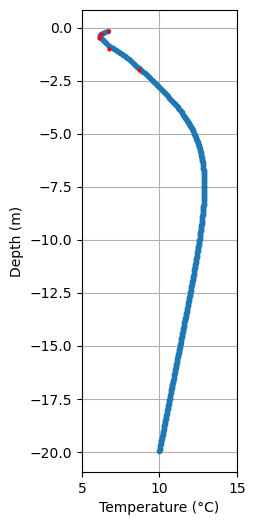

In [85]:
# Extract temperature curve for specific date
fig, ax = plt.subplots(figsize=(2, 6))
wunschdatum  = datetime.strptime('2023-12-24T15:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
tage = wunschdatum - start_date_datetime
number = np.where((np.array(t) < (tage.total_seconds()+3600) ) & ((tage.total_seconds()-3600) < np.array(t)) )[0][0]
ax.plot(T[number], -x, '.')
ax.plot(tiefe_15cm(pos=0, time=t[number]), -0.15, '.', color = 'red', markersize=4)
ax.plot(tiefe_30cm(pos=0, time=t[number]), -0.3, '.', color = 'red', markersize=4)
ax.plot(tiefe_50cm(pos=0, time=t[number]), -0.5, '.', color = 'red', markersize=4)
ax.plot(tiefe_100cm(pos=0, time=t[number]), -1, '.', color = 'red', markersize=4)
ax.plot(tiefe_200cm(pos=0, time=t[number]), -2, '.', color = 'red', markersize=4)

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.grid(True)
ax.set_xlim([5,15])
fig.savefig('./Fig5/' + 'T_Profil_%s_%s.png' 
            % (wunschdatum.strftime('%Y-%m-%d-%HH'), str(round(k,9)[0])), bbox_inches = 'tight', dpi=300)
paare = np.column_stack((-x, T[number]))
np.save('./Temp_profiles/' + 'T_Profil_%s_%s.npy' 
            % (wunschdatum.strftime('%Y-%m-%d-%HH'), str(round(k,9)[0])), paare)

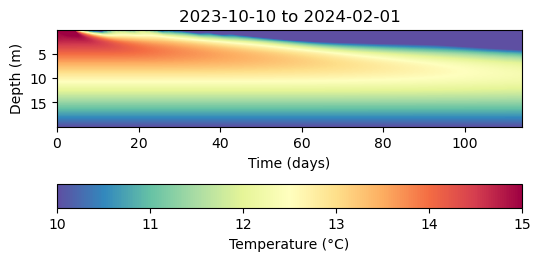

In [101]:
# Temperature evolution
time_difference = end_date_datetime - start_date_datetime
days = time_difference.days
fig, ax = plt.subplots(figsize=(6, 5))
kw = dict(extent=[0, days, max(x), min(x)], vmin=10, vmax=15,
          interpolation="nearest", cmap="Spectral_r")
im = ax.imshow(T.T, **kw)
fig.colorbar(im, orientation="horizontal", label="Temperature (°C)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Depth (m)")
ax.set_title(start_date_datetime.strftime('%Y-%m-%d') + ' to ' + end_date_datetime.strftime('%Y-%m-%d') )#+ ', k=' + str(round(k[0],8)))
ax.set_aspect(1.2)
fig.savefig('./Fig5/'  + 'T_Profil_%s_to_ %s.png' 
            % (start_date_datetime.strftime('%Y-%m-%d'), end_date_datetime.strftime('%Y-%m-%d')), bbox_inches = 'tight', dpi=300)

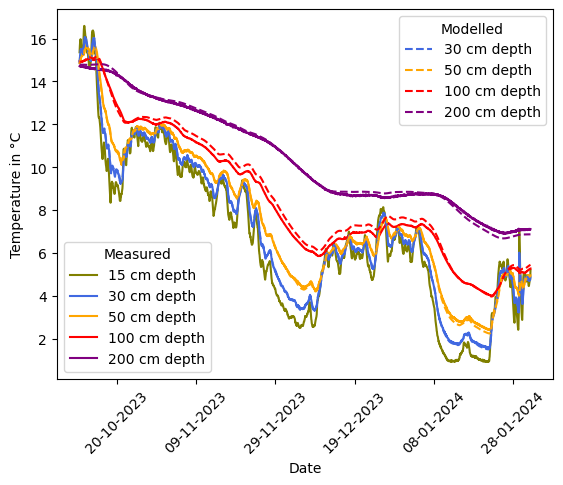

In [93]:
num_points_per_dataset = len(daten) // 4

# Divide data in different datasets
daten_1 = daten[:num_points_per_dataset]
daten_2 = daten[num_points_per_dataset:2*num_points_per_dataset]
daten_3 = daten[2*num_points_per_dataset:3*num_points_per_dataset]
daten_4 = daten[3*num_points_per_dataset:]
num_points_per_dataset = len(inv.response) // 4

inv_response_1 = inv.response[:num_points_per_dataset]
inv_response_2 = inv.response[num_points_per_dataset:2*num_points_per_dataset]
inv_response_3 = inv.response[2*num_points_per_dataset:3*num_points_per_dataset]
inv_response_4 = inv.response[3*num_points_per_dataset:]

line0, = plt.plot(datetimes, d_15cm, color='olive', label='15 cm depth')
line1, = plt.plot(datetimes, daten_1, '-', color='royalblue', label='30 cm depth')
line2, = plt.plot(datetimes, daten_2, '-', color='orange', label='50 cm depth')
line3, = plt.plot(datetimes, daten_3, '-', color='red', label='100 cm depth')
line4, = plt.plot(datetimes, daten_4, '-', color='purple', label='200 cm depth')

inv_line1, = plt.plot(datetimes, inv_response_1, '--', color='royalblue', label='30 cm depth')
inv_line2, = plt.plot(datetimes, inv_response_2, '--', color='orange', label='50 cm depth')
inv_line3, = plt.plot(datetimes, inv_response_3, '--', color='red', label='100 cm depth')
inv_line4, = plt.plot(datetimes, inv_response_4, '--', color='purple', label='200 cm depth')

# Legend
legend1 = plt.legend(handles=[line0, line1, line2, line3, line4], title='Measured', loc='lower left')
legend2 = plt.legend(handles=[inv_line1, inv_line2, inv_line3, inv_line4], title='Modelled', loc='upper right')

plt.gca().add_artist(legend1)
plt.xlabel('Date')
plt.ylabel('Temperature in °C')

# x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y')) # Format: Tag-Monat-Jahr
plt.xticks(rotation=45)
# y-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=20))

plt.savefig('./Fig4/' + 'Response_and_data.png' ,bbox_inches = 'tight', dpi=300)